In [1]:
from qslamr import ParticleFilter 
from qslamdesignparams import GRIDDICT, MODELDESIGN, NOISEPARAMS, FIX_LAMBDAS
import numpy as np
import matplotlib.pyplot as plt

This workbook is to resolve a bug in the code. This bug means that the code is breaking upon iteration. The algorithm runs a single iteration without any problems with the following settings:

In [2]:
# MODELDESIGN["MSMTS_PER_NODE"] = 20 # Works for all values
# TOT_MSMTS = 1 # Works for only on value

However, changing the number of total measurements on potentially different qubits yields a break.

In [3]:
# MODELDESIGN["MSMTS_PER_NODE"] = 20 # Works for all values
# TOT_MSMTS = 2 # Doesn't work for all values

#### Bug testing 

**IDEA 1** We know that the break occurs when the last particle in a set of Alpha particles fails to generate a Beta Layer. We will now try to replicate the error by choosing only 1 Alpha particle and 1 Beta particle.

In [4]:
# MODELDESIGN["P_ALPHA"] = 1
# MODELDESIGN["P_BETA"] = 1
# MODELDESIGN["MSMTS_PER_NODE"] = 1 # Works for all values
# TOT_MSMTS = 2 # Works for P_ALPHA == P_BETA = 1

** Result 1** The algorithm appears to work for a single Alpha and a single Beta particle.

**IDEA 2** We know that for single particle types, the algorithm works. We know that the beta layer generation for an alpha parent fails. We will keep the parent constant (single Alpha particle), and see if algorithms runs by generating Beta layers in multiple iterations if the parent is held constant. This shows that the generation and collapse of beta layers will be working correctly for a single parent outcome. Hence, we test the error by choosing 1 Alpha particle but >1 Beta particles.

In [5]:
# MODELDESIGN["P_ALPHA"] = 1
# MODELDESIGN["P_BETA"] = 10
# MODELDESIGN["MSMTS_PER_NODE"] = 5 # Works for all values
# TOT_MSMTS = 50 # Works for P_ALPHA == P_BETA = 1

** Result 2** 

** 2.1 **  We increase the number of measurements in the above settings:

    MODELDESIGN["P_ALPHA"] = 1
    MODELDESIGN["P_BETA"] = 2
    MODELDESIGN["MSMTS_PER_NODE"] = 1 
    TOT_MSMTS = 20 

A new error message was receieved:
        
        Traceback in line 96 of:
             /home/riddhisw/Documents/SLAM_project/qslam/control_action.pyc in control_lengthscale_uncertainty(listofcontrolparameters, next_control_neighbourhood, number_of_diff_nodes, dtype)
        ``global name 'number_of_nodes' is not defined``

This is a local variable name error: `number_of_nodes` should be `number_of_diff_nodes`. It did not show up before.

** 2.2 ** With the local name fix,  **2.1** is resolved. Further, algorithm works for a large number of beta particles and large number of measurements, for example:

    MODELDESIGN["P_ALPHA"] = 1
    MODELDESIGN["P_BETA"] = 10
    MODELDESIGN["MSMTS_PER_NODE"] = 10
    TOT_MSMTS = 50 

Observations:
- for a uniform field, less number of beta particles improves performance
- increase in number of measurements per node improves performance
- the location of the measurements via the auto-controller works "through" the grid
- qubits at the eddges of the grid don't have good estimates as they are not in enclosed neighbourhoods.
- an alternative smoothening function (applied globally) might be the next thing on the list
- changing lambda for simple cases doesn't do much - this means the way we're sharing info with other qubits isn't making a difference compared to the "no sharing " case.
- further for the toy model in uniform field case, it takes 250 measurements to approximate a uniform field. In practice, one should sample from long correlation lengths, and as more iterations are require with large residuals, one should expand the prior for r to include smaller and smaller variations. 


** IDEA 3 ** In Result 2.2 we confirmed that for a single Alpha parent, a beta layer can be generated and collapsed for the following parameter regime changes:
- number of total measurement (different qubits) - TOT_MSMTS
- number of beta particles in each layer
- number of qubit measurements at a single node before sharing info globally
    
We note that if number of beta particles is larger than number of total measurement (different qubits), then the Posterior weights tend to fail (namely, there is not enough info about spatial field variation captured relative to number of beta particles embodying variation in true length scales). 

Now we revert to a simple case where multiple Alpha parents exist and all other parameters are unity.

In [6]:
# MODELDESIGN["P_ALPHA"] = 3
# MODELDESIGN["P_BETA"] = 2
# MODELDESIGN["MSMTS_PER_NODE"] = 1
# TOT_MSMTS = 4

** Result 3.1 ** : In the following parameter regime, the model works some of the time but not all:

    MODELDESIGN["P_ALPHA"] = 2
    MODELDESIGN["P_BETA"] = 1
    MODELDESIGN["MSMTS_PER_NODE"] = 1
    TOT_MSMTS = 2
    
If it fails, the last function in the traceback error message is:

    /home/riddhisw/Documents/SLAM_project/qslam/qslamr.pyc in collapse_beta(self, subtree_list, resampled_indices)
        617 
        618                 for node in beta_alpha_nodes:
    --> 619                     beta_state = self.AlphaSet.particles[alpha_node].BetaAlphaSet_j.particles[node].particle.copy()
        620                     beta_lengthscale = beta_state[r_est_index]*1.0
        621                     if np.isnan(beta_lengthscale):

    AttributeError: 'NoneType' object has no attribute 'particles'
    
*Symptom: self.AlphaSet.particles[alpha_node].BetaAlphaSet_j == None.*
Direct cause: 
- There is no Beta layer for an Alpha parent
Indirect causes:
- Alpha parent fails to generate the Beta layer
- Alpha parent generates the Beta layer but it is overwritten to `None` later in the code

*Symptom: only affects algorithm when more than 1 Alpha particle exists (and possibly, the last Alpha particle in the list has no Beta layer)*
Indirect causes:
- Alpha parent resampling procedures (and collapsing procedures) are flawed
- Alpha particle generation is flawed

*Symptom: only affects algorithm when more than one iteration exists: TOT_MSMTS > 1*
Indirect causes:
- Carry-over of alpha particles from one iteration to the next is buggy, initialisation is okay

*Symptom: only affects algorithm some of the time, not all of the time, when if TOT_MSMTS > 1 and number of Alpha particles > 1*
- an if-condition is being met only some of the time (randomly) and the if_subloop is incorrect
- some other edge case is triggered only some (not all) of the time
    - e.g. no particles are sampled from an Alpha parent after resampling
    - e.g. for-loop terminates prematurely for an edge case Alpha particle (?) and we fail to generate Alpha weights
    - e.g. indexing of Alpha particle accidentally sets the last Alpha weights to zero
- theoretical underpinnign of the code is random, so code will initialise randomly in an area of no convergence [unlikely, as theory failure should manifest as a failure of calculating finite weights].


** Result 3.2 ** : We now reduce the number of qubits to 2x2 Grid and create the error. 

    DIMS = 2
    MODELDESIGN["P_ALPHA"] = 2
    MODELDESIGN["P_BETA"] = 1
    MODELDESIGN["MSMTS_PER_NODE"] = 1
    TOT_MSMTS = 2
    
Observations:
- The Alpha Particles are identical
- Both Alpha particles have not generated a Beta Particle list
- Manually, it is posible to call AlphaParticle.generate_beta_pset() and confirm with AlphaParticle.BetaAlphaSet_j that one can generate a Beta layer without any bugs
- Since this error only happens some of the time, it must be a bad edge case manifesting as an incorrect for loop / if conditional 
- Need to follow a Alpha particle from the end of the run to the beginning of the run

#### PROBABLE CULPRIT

In `self.collapse_beta()`:

** self.AlphaSet.particles[alpha_node].BetaAlphaSet_j = None **
    
    # COMMENT: This line of code resets beta layers for an alpha 
    # parent. This code only works if the alpha_nodes are unique. For 
    # alpha parents that are not unique, it will wipe out the BetaLayer
    # and the loop over sub-trees will fail if the parent is repeated.
    # For re-sampled parents, we will use null_beta_layer() function
    # to kill the beta layer for an Alpha parent. 


#### SOLUTION

Implement new function, `self.null_beta_layer()` that sets a Beta ParticleSet object to `None`. The function `self.null_beta_layer(`) is called just before returning the output of `self.collapse_beta()` so that is does not mess with any resampling of Alpha particles.

The function is defined simply as:

    def null_beta_layer(self, list_of_alpha_particles):
        ''' Strips input list of Alpha particles of its individual Beta layers '''

        for alpha_idx in list_of_alpha_particles:
            alpha_idx.BetaAlphaSet_j = None
            
We now test the bug fully for all possible configurations of parameters:

In [7]:
MODELDESIGN["P_ALPHA"] = 10
MODELDESIGN["P_BETA"] = 3
MODELDESIGN["MSMTS_PER_NODE"] = 15
TOT_MSMTS = 10

####  TOY MODEL: UNIFORM FIELD OVER 3x3 QUBITS

The standard parameters under which to run this algoirithm are given as below. It is suspected that the errors relating to a poor initiation of the algorithm's basic configuration (e.g. choice of prior distribution and noise variance parameters) are not relevant to the bug at hand. 

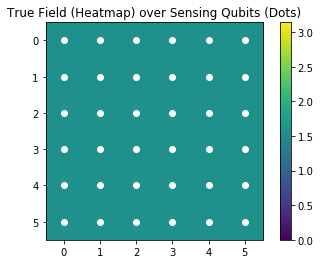

In [8]:
''' STANDARD SIMULATION SETTINGS
'''
data_file_name="bugtestingnewfunctionality"
MODELDESIGN["MULTIPLER_R_MAX"] = 1.0
TOT_CNTL = 1
REPTS = 1

''' QUBIT GRID POSITIONS + TRUE FIELD OVER QUBITS
'''
DIMS = 6
MUX = 2.
MUY = 2.
VAR = 0.8
positions=[]
true_noise_map =[]
count=1
GRIDDICT={}
for xidx in range(DIMS):
    for yidx in range(DIMS):
        GRIDDICT["QUBIT_"+str(count)] = (float(xidx), float(yidx))
        positions.append(GRIDDICT["QUBIT_"+str(count)])
        truephase = 0.5*np.pi #2.5*np.pi*(1.0 / (np.sqrt(2.0*np.pi*VAR)))*np.exp(-((float(xidx) - MUX)**2 + (float(yidx) - MUY)**2)/ 2*VAR)
        if truephase > np.pi:
            truephase = np.pi
        true_noise_map.append(truephase)
        count +=1
        
NUM_QUBITS = len(GRIDDICT.keys())

true_noise_mapgrid = np.asarray(true_noise_map).reshape(DIMS, DIMS)

fig = plt.figure()
ax = fig.add_subplot(1,1,1)

for key in sorted(GRIDDICT.keys()):
    x = GRIDDICT[key][0]
    y = GRIDDICT[key][1]
    ax.plot(x, y, 'wo')

im = ax.imshow(true_noise_mapgrid, vmin=0, vmax=np.pi)
plt.title("True Field (Heatmap) over Sensing Qubits (Dots)")
plt.colorbar(im)
plt.show()

#### RUN 

In [9]:
rms_errors_matrix = np.zeros((TOT_CNTL, NUM_QUBITS, REPTS))
posteriors_matrix = np.zeros((TOT_CNTL, NUM_QUBITS*4, REPTS))
alpha_set_matrix = np.zeros((TOT_CNTL, MODELDESIGN['P_ALPHA'], NUM_QUBITS*4, REPTS))

idx_msmt=0

for idx_cntl in range(TOT_CNTL):

    for idx_run in range(REPTS):

        test = ParticleFilter(positions, **MODELDESIGN)
        test.QubitGrid.engineeredtruemap = true_noise_map
        test.qslamr(autocontrol="ON", cutoff_msmt=TOT_MSMTS, var_thres=0.000001)

        posteriors_matrix[idx_cntl, :, idx_run] = test.QubitGrid.state_vector
        
        for idx_alpha in range(len(test.AlphaSet.particles)):
            alpha_set_matrix[idx_cntl, idx_alpha, :, idx_run] = test.AlphaSet.particles[idx_alpha].particle
        
        np.savez(data_file_name,
                 GRIDDICT=GRIDDICT,
                 MODELDESIGN=MODELDESIGN,
                 NOISEPARAMS=NOISEPARAMS,
                 NUM_QUBITS=NUM_QUBITS,
                 posteriors_matrix=posteriors_matrix,
                 alpha_set_matrix=alpha_set_matrix,
                 weight_set = test.AlphaSet.weights_set,
                 REPTS=REPTS,
                 control_sequence = test.QubitGrid.control_sequence,
                 true_noise_map=true_noise_map)

Zero value normalisation in ComputePosteriorWeights()
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
PROTOCOL - SAFE END - Max number of measurements taken


#### SIMPLE CHECKS

We now do a bunch of simple checks to make sure that we are producing the correct output.

Check the simulation parameters:

In [10]:
print " Total num of qubits:", test.QubitGrid.number_of_nodes
psetalpha = len(test.AlphaSet.particles)
print " Total num of Alpha particles:", psetalpha, ", matches internal attributes: ", psetalpha==test.AlphaSet.p_set
print " Total num of Beta particles:",  test.AlphaSet.particles[0].pset_beta
print " Number of measurements per node", test.MODELDESIGN["MSMTS_PER_NODE"]
print " Total Control length", len(test.QubitGrid.control_sequence)
print "     The control sequence was:"
print "     ", test.QubitGrid.control_sequence

 Total num of qubits: 36
 Total num of Alpha particles: 10 , matches internal attributes:  True
 Total num of Beta particles: 3
 Number of measurements per node 15
 Total Control length 150
     The control sequence was:
      [15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12]


Check the Qubit Grid State Vector

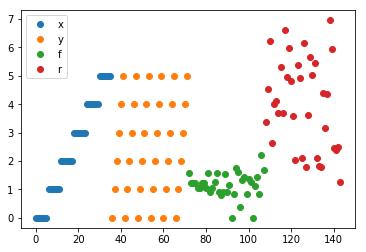

In [11]:
state = ['x', 'y', 'f', 'r']

plt.figure
for idx in range(4):
    start = idx*NUM_QUBITS
    end = idx*NUM_QUBITS + NUM_QUBITS
    x = range(start, end, 1 )
    y = test.QubitGrid.state_vector[start:end]
    plt.plot(x,y,'o', label=state[idx])
plt.legend(loc=2)
plt.show()

Check Alpha Posterior State

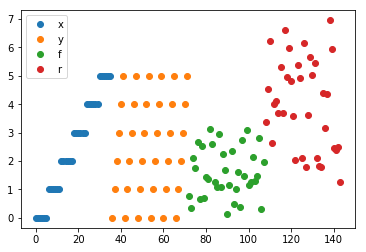

In [12]:
state = ['x', 'y', 'f', 'r']

plt.figure
for idx in range(4):
    start = idx*NUM_QUBITS
    end = idx*NUM_QUBITS + NUM_QUBITS
    x = range(start, end, 1 )
    y = test.AlphaSet.posterior_state[start:end]
    plt.plot(x,y,'o', label=state[idx])
plt.legend(loc=2)
plt.show()

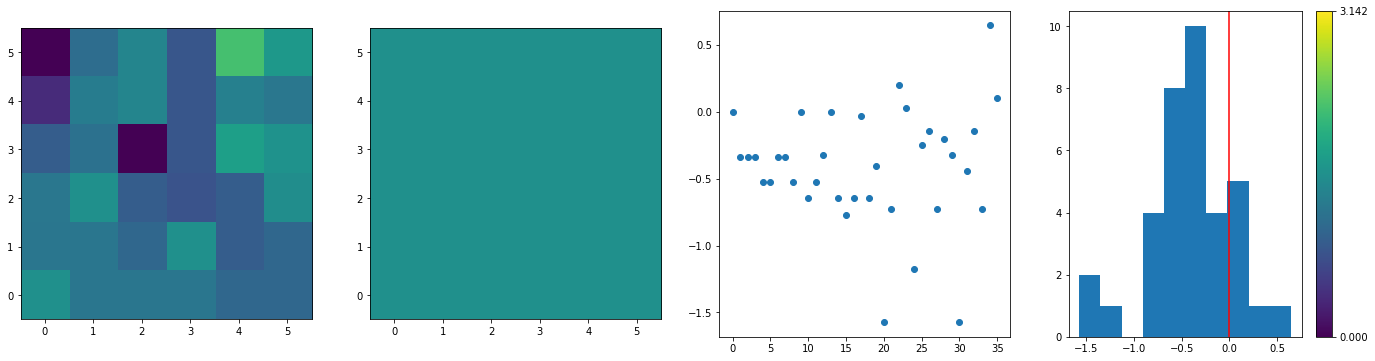

In [13]:
output_map = posteriors_matrix[0,test.QubitGrid.number_of_nodes*2:test.QubitGrid.number_of_nodes*3,0].reshape(DIMS, DIMS)
true_map = np.asarray(test.QubitGrid.engineeredtruemap).reshape(DIMS, DIMS)
total_error = (output_map - true_map)

fig = plt.figure(figsize=(24,6))
ax1 = fig.add_subplot(1,4,1)
ax2 = fig.add_subplot(1,4,2)
ax3 = fig.add_subplot(1,4,3)
ax4 = fig.add_subplot(1,4,4)

ax1.imshow(output_map, cmap='viridis', vmin=0, vmax=np.pi, origin="lower")
cax = ax2.imshow(true_map, cmap='viridis', vmin=0, vmax=np.pi, origin="lower")

cbar = fig.colorbar(cax, ticks=[0.0, np.pi], orientation='vertical')
cbar.ax.set_xticklabels([['0.0', r'$\pi$']])  # horizontal colorbar

ax3.plot(total_error.flatten(), 'o')
ax4.hist(total_error.flatten())
ax4.axvline(x=0.0, c='r')

plt.show()